# Text Generation with Neural Networks

In this notebook we will create a network that can generate text, here we show it being done character by character. Very awesome write up on this here: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

We organized the process into "steps" so you can easily follow along with your own data sets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 1: The Data

You can grab any free text you want from here: https://www.gutenberg.org/

We'll choose all of shakespeare's works (which we have already downloaded for you), mainly for two reasons:

1. Its a large corpus of text, its usually recommended you have at least a source of 1 million characters total to get realistic text generation.

2. It has a very distinctive style. Since the text data uses old style english and is formatted in the style of a stage play, it will be very obvious to us if the model is able to reproduce similar results.

In [4]:
text = open('shakespeare.txt', 'r').read()

In [5]:
type(text)

str

In [6]:
len(text)

5445609

In [7]:
print(text[:667])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.




### Understanding unique characters

In [8]:
# The unique characters in the file
vocab = sorted(set(text))
print(vocab)
len(vocab)

['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}']


84

## Step 2: Text Processing

### Text Vectorization

We know a neural network can't take in the raw string data, we need to assign numbers to each character. Let's create two dictionaries that can go from numeric index to character and character to numeric index.

In [9]:
# creating a dict
char_to_ind = {char:ind for ind, char in enumerate(vocab)}

In [10]:
char_to_ind

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 '&': 4,
 "'": 5,
 '(': 6,
 ')': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '0': 11,
 '1': 12,
 '2': 13,
 '3': 14,
 '4': 15,
 '5': 16,
 '6': 17,
 '7': 18,
 '8': 19,
 '9': 20,
 ':': 21,
 ';': 22,
 '<': 23,
 '>': 24,
 '?': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'X': 49,
 'Y': 50,
 'Z': 51,
 '[': 52,
 ']': 53,
 '_': 54,
 '`': 55,
 'a': 56,
 'b': 57,
 'c': 58,
 'd': 59,
 'e': 60,
 'f': 61,
 'g': 62,
 'h': 63,
 'i': 64,
 'j': 65,
 'k': 66,
 'l': 67,
 'm': 68,
 'n': 69,
 'o': 70,
 'p': 71,
 'q': 72,
 'r': 73,
 's': 74,
 't': 75,
 'u': 76,
 'v': 77,
 'w': 78,
 'x': 79,
 'y': 80,
 'z': 81,
 '|': 82,
 '}': 83}

In [11]:
ind_to_char = np.array(vocab)

In [12]:
ind_to_char

array(['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
       'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
       'w', 'x', 'y', 'z', '|', '}'], dtype='<U1')

In [13]:
encoded_text = np.array([char_to_ind[c] for c in text])

We now have a mapping we can use to go back and forth from characters to numerics.

In [14]:
encoded_text[:667]

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12,  0,  1,  1, 31, 73, 70, 68,  1, 61, 56, 64,
       73, 60, 74, 75,  1, 58, 73, 60, 56, 75, 76, 73, 60, 74,  1, 78, 60,
        1, 59, 60, 74, 64, 73, 60,  1, 64, 69, 58, 73, 60, 56, 74, 60,  8,
        0,  1,  1, 45, 63, 56, 75,  1, 75, 63, 60, 73, 60, 57, 80,  1, 57,
       60, 56, 76, 75, 80,  5, 74,  1, 73, 70, 74, 60,  1, 68, 64, 62, 63,
       75,  1, 69, 60, 77, 60, 73,  1, 59, 64, 60,  8,  0,  1,  1, 27, 76,
       75,  1, 56, 74,  1, 75, 63, 60,  1, 73, 64, 71, 60, 73,  1, 74, 63,
       70, 76, 67, 59,  1, 57, 80,  1, 75, 64, 68, 60,  1, 59, 60, 58, 60,
       56, 74, 60,  8,  0,  1,  1, 33, 64, 74,  1, 75, 60, 69, 59, 60, 73,
        1, 63, 60, 64, 73,  1, 68, 64, 62, 63, 75,  1, 57, 60, 56, 73,  1,
       63, 64, 74,  1, 68, 60, 68, 70, 73, 80, 21,  0,  1,  1, 27, 76, 75,
        1, 75, 63, 70, 76,  1, 58, 70, 69, 75, 73, 56, 58, 75, 60, 59,  1,
       75, 70,  1, 75, 63

## Step 3: Creating Batches

Overall what we are trying to achieve is to have the model predict the next highest probability character given a historical sequence of characters. Its up to us (the user) to choose how long that historic sequence. Too short a sequence and we don't have enough information (e.g. given the letter "a" , what is the next character) , too long a sequence and training will take too long and most likely overfit to sequence characters that are irrelevant to characters farther out. While there is no correct sequence length choice, you should consider the text itself, how long normal phrases are in it, and a reasonable idea of what characters/words are relevant to each other.

In [15]:
print(text[:500])


                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bu


In [16]:
# first line
line = 'From fairest creatures we desire increase,'

In [17]:
len(line)

42

In [18]:
# catching the pattern
part_stanza = """From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,"""

In [19]:
len(part_stanza)

131

### Training Sequences

The actual text data will be the text sequence shifted one character forward. For example:

**Sequence In: "Hello my nam"**

**Sequence Out: "ello my name"**


We can use the `tf.data.Dataset.from_tensor_slices` function to convert a text vector into a stream of character indices (dataset).

In [20]:
seq_len = 120

In [21]:
# +1: avoid ind 0 
total_num_seq = len(text)//(seq_len+1)

In [22]:
total_num_seq

45005

In [23]:
# Create Training Sequences (dataset)
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

In [24]:
# example
for i in char_dataset.take(50):
     print(i.numpy())

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
12
0
1
1
31
73
70
68
1
61
56
64
73
60
74
75
1
58
73
60
56
75
76
73
60
74
1
78


In [25]:
# to char - example
for i in char_dataset.take(50):
     print(ind_to_char[i.numpy()])



 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
1


 
 
F
r
o
m
 
f
a
i
r
e
s
t
 
c
r
e
a
t
u
r
e
s
 
w


The **batch** method converts these individual character calls into sequences we can feed in as a batch. We use seq_len+1 because of zero indexing. Here is what drop_remainder means:

drop_remainder: (Optional.) A `tf.bool` scalar `tf.Tensor`, representing
    whether the last batch should be dropped in the case it has fewer than
    `batch_size` elements; the default behavior is not to drop the smaller
    batch.


In [26]:
sequences = char_dataset.batch(batch_size=seq_len+1, drop_remainder=True)

Now that we have our sequences, we will perform the following steps for each one to create our target text sequences:

1. Grab the input text sequence
2. Assign the target text sequence as the input text sequence shifted by one step forward
3. Group them together as a tuple

In [27]:
def create_seq_targets(seq):
    input_txt = seq[:-1] # grab input sequence
    target_txt = seq[1:] # shift 1
    return input_txt, target_txt # return a tuple

In [28]:
dataset = sequences.map(create_seq_targets)

In [29]:
# example
for input_txt, target_txt in dataset.take(1):
    print(input_txt.numpy())
    print(''.join(ind_to_char[input_txt.numpy()]))
    print('\n')

    print(target_txt.numpy())
    print(''.join(ind_to_char[target_txt.numpy()]))     # There is an extra whitespace at the end!

[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0
  1  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74
  1 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45
 63 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74
 60  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75]

                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12  0  1
  1 31 73 70 68  1 61 56 64 73 60 74 75  1 58 73 60 56 75 76 73 60 74  1
 78 60  1 59 60 74 64 73 60  1 64 69 58 73 60 56 74 60  8  0  1  1 45 63
 56 75  1 75 63 60 73 60 57 80  1 57 60 56 76 75 80  5 74  1 73 70 74 60
  1 68 64 62 63 75  1 69 60 77 60 73  1 59 64 60  8  0  1  1 27 76 75  1]
                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But 


### Generating training batches

Now that we have the actual sequences, we will create the batches, we want to shuffle these sequences into a random order, so the model doesn't overfit to any section of the text, but can instead generate characters given any seed text.

In [30]:
# Batch size - 128 sequences per time
batch_size = 128

In [31]:
# Buffer size to shuffle the dataset so it doesn't attempt to shuffle the
# entire sequence in memory. Instead, it maintains a buffer in which it shuffles elements
buffer_size = 10000

dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [32]:
# (input text), (target text), 128 sequences of length 120
dataset

<BatchDataset shapes: ((128, 120), (128, 120)), types: (tf.int64, tf.int64)>

## Step 4: Creating the Model

We will use an LSTM based model with a few extra features, including an embedding layer to start off with and **two** LSTM layers. We based this model architecture off the [DeepMoji](https://deepmoji.mit.edu/) and the original source code can be found [here](https://github.com/bfelbo/DeepMoji).

The embedding layer will serve as the input layer, which essentially creates a lookup table that maps the numbers indices of each character to a vector with "embedding dim" number of dimensions. As you can imagine, the larger this embedding size, the more complex the training. This is similar to the idea behind word2vec, where words are mapped to some n-dimensional space. Embedding before feeding straight into the LSTM usually leads to more realisitic results.

In [33]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension - more or less the same range as the vocab size
embed_dim = 64

# Number of RNN units
rnn_neurons = 1026

Now let's create a function that easily adapts to different variables as shown above.

### Setting up Loss Function

For our loss we will use sparse categorical crossentropy, which we can import from Keras. We will also set this as logits=True

In [34]:
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [35]:
# help(sparse_categorical_crossentropy)

https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy

In [36]:
# custom loss function - just setting 'from_logits=True'
def sparse_cat_loss(y_true,y_pred):
  return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True) # True because is hot encoded

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU

In [38]:
def create_model(vocab_size, embed_dim, rnn_neurons, batch_size):
    model = Sequential()

    # ebbedding layer
    model.add(Embedding(vocab_size, embed_dim,batch_input_shape=[batch_size, None]))

    # GRU layer
    model.add(GRU(rnn_neurons,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))

    # Final Dense Layer to Predict
    model.add(Dense(vocab_size))

    # this is why we custom our loss fuction, we couldn't take 'from_logits=True'
    model.compile(optimizer='adam', loss=sparse_cat_loss) 
    return model

In [39]:
model = create_model(
  vocab_size = vocab_size,
  embed_dim=embed_dim,
  rnn_neurons=rnn_neurons,
  batch_size=batch_size)

In [40]:
# over 3 million parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 64)           5376      
_________________________________________________________________
gru (GRU)                    (128, None, 1026)         3361176   
_________________________________________________________________
dense (Dense)                (128, None, 84)           86268     
Total params: 3,452,820
Trainable params: 3,452,820
Non-trainable params: 0
_________________________________________________________________


## Step 5: Training the model

Let's make sure everything is ok with our model before we spend too much time training! Let's pass in a batch to confirm the model currently predicts random characters without any training.


In [41]:
for input_example_batch, target_example_batch in dataset.take(1):

  # Predict off some random batch
  example_batch_predictions = model(input_example_batch)

In [42]:
# Display the dimensions of the predictions
print(example_batch_predictions.shape, " <=== (batch_size, sequence_length, vocab_size)")

(128, 120, 84)  <=== (batch_size, sequence_length, vocab_size)


In [43]:
# bunch of probabilities
example_batch_predictions[0]

<tf.Tensor: shape=(120, 84), dtype=float32, numpy=
array([[ 2.2651225e-03,  4.2362134e-03,  7.9701003e-03, ...,
         2.7453364e-03,  5.3335740e-03, -3.6167685e-04],
       [-1.8203349e-03, -1.2814200e-03, -4.1319137e-03, ...,
         9.3049504e-04,  4.2154975e-03, -2.1727295e-03],
       [ 1.0184464e-02,  6.6103837e-03, -3.6684514e-04, ...,
         6.0710083e-03,  9.5062172e-03,  2.4454057e-04],
       ...,
       [-1.0415519e-03, -4.6648504e-04, -2.9199801e-03, ...,
         5.8670726e-04,  1.4195786e-02, -1.2188540e-03],
       [-3.2216355e-03,  1.2084367e-02,  3.1386609e-03, ...,
        -1.2192044e-03,  3.2164655e-03,  3.5958568e-05],
       [ 7.6738838e-03,  1.2011437e-02,  5.6343707e-03, ...,
         3.3168532e-03,  8.3425911e-03,  8.8554836e-04]], dtype=float32)>

In [44]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)

In [45]:
sampled_indices

<tf.Tensor: shape=(120, 1), dtype=int64, numpy=
array([[44],
       [65],
       [55],
       [48],
       [67],
       [41],
       [51],
       [42],
       [55],
       [62],
       [ 0],
       [74],
       [25],
       [18],
       [48],
       [27],
       [39],
       [49],
       [10],
       [49],
       [48],
       [80],
       [67],
       [54],
       [61],
       [ 2],
       [78],
       [56],
       [70],
       [35],
       [ 2],
       [11],
       [74],
       [ 1],
       [77],
       [74],
       [24],
       [30],
       [22],
       [42],
       [20],
       [44],
       [35],
       [49],
       [13],
       [48],
       [56],
       [22],
       [36],
       [42],
       [ 8],
       [55],
       [31],
       [ 9],
       [38],
       [33],
       [11],
       [50],
       [32],
       [81],
       [22],
       [68],
       [74],
       [48],
       [16],
       [46],
       [73],
       [54],
       [ 9],
       [17],
       [21],
       [33],
       [79],
   

In [46]:
# Reformat to not be a lists of lists
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [47]:
sampled_indices

array([44, 65, 55, 48, 67, 41, 51, 42, 55, 62,  0, 74, 25, 18, 48, 27, 39,
       49, 10, 49, 48, 80, 67, 54, 61,  2, 78, 56, 70, 35,  2, 11, 74,  1,
       77, 74, 24, 30, 22, 42, 20, 44, 35, 49, 13, 48, 56, 22, 36, 42,  8,
       55, 31,  9, 38, 33, 11, 50, 32, 81, 22, 68, 74, 48, 16, 46, 73, 54,
        9, 17, 21, 33, 79, 25, 30, 73, 61,  8, 36, 82, 34, 31, 30, 52, 59,
       51, 50, 38, 58, 53, 25, 29, 45, 47, 27, 24, 69, 12, 44,  9, 35, 72,
        9, 82, 82, 24, 62, 77, 14, 38, 23, 34, 62, 41, 63, 75, 36, 27,  8,
       79])

In [48]:
ind_to_char[sampled_indices]

array(['S', 'j', '`', 'W', 'l', 'P', 'Z', 'Q', '`', 'g', '\n', 's', '?',
       '7', 'W', 'B', 'N', 'X', '.', 'X', 'W', 'y', 'l', '_', 'f', '!',
       'w', 'a', 'o', 'J', '!', '0', 's', ' ', 'v', 's', '>', 'E', ';',
       'Q', '9', 'S', 'J', 'X', '2', 'W', 'a', ';', 'K', 'Q', ',', '`',
       'F', '-', 'M', 'H', '0', 'Y', 'G', 'z', ';', 'm', 's', 'W', '5',
       'U', 'r', '_', '-', '6', ':', 'H', 'x', '?', 'E', 'r', 'f', ',',
       'K', '|', 'I', 'F', 'E', '[', 'd', 'Z', 'Y', 'M', 'c', ']', '?',
       'D', 'T', 'V', 'B', '>', 'n', '1', 'S', '-', 'J', 'q', '-', '|',
       '|', '>', 'g', 'v', '3', 'M', '<', 'I', 'g', 'P', 'h', 't', 'K',
       'B', ',', 'x'], dtype='<U1')

In [49]:
print("Given the input seq: \n")
print("".join(ind_to_char[input_example_batch[0]]))
print('\n')
print("Next Char Predictions: \n")
print("".join(ind_to_char[sampled_indices ]))

Given the input seq: 

miling to my heart; in grace whereof,
    No jocund health that Denmark drinks to-day
    But the great cannon to the cl


Next Char Predictions: 

Sj`WlPZQ`g
s?7WBNX.XWyl_f!waoJ!0s vs>E;Q9SJX2Wa;KQ,`F-MH0YGz;msW5Ur_-6:Hx?Erf,K|IFE[dZYMc]?DTVB>n1S-Jq-||>gv3M<IgPhtKB,x


### Train our network!

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stop = EarlyStopping(monitor='loss', patience=2)

In [53]:
model.fit(dataset,epochs=30, callbacks=[early_stop])

Epoch 1/30
351/351 [==============================] - 53s 148ms/step - loss: 1.5667
Epoch 2/30
351/351 [==============================] - 53s 147ms/step - loss: 1.3877
Epoch 3/30
351/351 [==============================] - 51s 142ms/step - loss: 1.3036
Epoch 4/30
351/351 [==============================] - 53s 149ms/step - loss: 1.2541
Epoch 5/30
351/351 [==============================] - 51s 142ms/step - loss: 1.2196
Epoch 6/30
351/351 [==============================] - 53s 147ms/step - loss: 1.1933
Epoch 7/30
351/351 [==============================] - 51s 143ms/step - loss: 1.1715
Epoch 8/30
351/351 [==============================] - 52s 145ms/step - loss: 1.1532
Epoch 9/30
351/351 [==============================] - 51s 144ms/step - loss: 1.1364
Epoch 10/30
351/351 [==============================] - 53s 149ms/step - loss: 1.1217
Epoch 11/30
351/351 [==============================] - 53s 148ms/step - loss: 1.1074
Epoch 12/30
351/351 [==============================] - 51s 142ms/step - lo

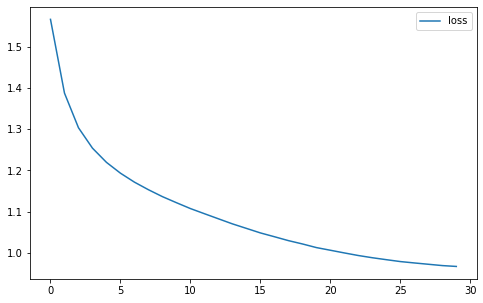

In [57]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.show()

### Saving model

In [58]:
model.save('shakespeare_text_gen.h5')

## Evaluating the model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
# importing the model in a different way
model = create_model(vocab_size, embed_dim, rnn_neurons, batch_size=1)

model.load_weights('shakespeare_text_gen.h5')

model.build(tf.TensorShape([1, None]))

In [71]:
def generate_text(model, start_seed,gen_size=100,temp=1.0):
  '''
  model: Trained Model to Generate Text
  start_seed: Intial Seed text in string form
  gen_size: Number of characters to generate

  Basic idea behind this function is to take in some seed text, format it so
  that it is in the correct shape for our network, then loop the sequence as
  we keep adding our own predicted characters. Similar to our work in the RNN
  time series problems.
  '''

  # Number of characters to generate
  num_generate = gen_size

  # Vecotrizing starting seed text
  input_eval = [char_to_ind[s] for s in start_seed]

  # Expand to match batch format shape
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty list to hold resulting generated text
  text_generated = []

  # Temperature effects randomness in our resulting text
  # The term is derived from entropy/thermodynamics.
  # The temperature is used to effect probability of next characters.
  # Higher probability == lesss surprising/ more expected
  # Lower temperature == more surprising / less expected
 
  temperature = temp

  # Here batch size == 1
  model.reset_states()

  for i in range(num_generate):

      # Generate Predictions
      predictions = model(input_eval)

      # Remove the batch shape dimension
      predictions = tf.squeeze(predictions, 0)

      # Use a cateogircal disitribution to select the next character
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the predicted charracter for the next input
      input_eval = tf.expand_dims([predicted_id], 0)

      # Transform back to character letter
      text_generated.append(ind_to_char[predicted_id])

  return (start_seed + ''.join(text_generated))

In [72]:
print(generate_text(model,"JULIET",gen_size=500))

JULIETH. Why?
  IACHIMO. That which we offer to me.
  LUCENTIO. Sir, 'tis too sad broad.'
  TROILUS. Farewell.
  AJAX. Alas!
  THERSITES. Sure he has not so much truly liep upon you. We dwell
    there must all they entle is but a dan's baskin?
DROMIO OF EPHESUS. Ay, for my Lord Claudio, let me know.
    I did not get my word for joy in any kind.
    He hath no still an antic Cyrimius.
    Take this for some good messenger.
  DESDEMONA. Why, then, there comes it straight, you mean and shame to fear
  


In [75]:
print(generate_text(model,"From fairest creatures",gen_size=500))

From fairest creatures
    To quickly part the juiches of their mercy.
  Rom. This day,
    Let them be distemper'd from my eyes.
  AARON. MASTINE. To be a fresher descriptioning than half, est,
    For I did the petty wretch were they as life
    Than you shall sun; and finding trans that we
    Must be that neither; but I know it is;
    His humour or my gentle and distempered.
  OXFORD. My Lord Aumerle.
  SEBASTIAN. A heart i' th' town!
  SECOND SERVANT. Ay, and well favours reason.
  SEBASTIAN. Why is this Dromio
